In [369]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

In [370]:
import random
import os

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


In [371]:
# Загрузка данных
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [372]:
print(train_data.isnull().sum())

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64


In [373]:
train_data.dtypes

,0
id,int64
age,float64
height(cm),float64
weight(kg),float64
waist(cm),float64
eyesight(left),float64
eyesight(right),float64
hearing(left),float64
hearing(right),float64
systolic,float64


Пробуем фича инжиниринг

In [374]:
# Заменяем нули на небольшие значения
train_data['weight(kg)'].replace(0, 0.1, inplace=True)
train_data['height(cm)'].replace(0, 0.1, inplace=True)
test_data['weight(kg)'].replace(0, 0.1, inplace=True)
test_data['height(cm)'].replace(0, 0.1, inplace=True)


<ipython-input-374-7b5923765004>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['weight(kg)'].replace(0, 0.1, inplace=True)
<ipython-input-374-7b5923765004>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [375]:
# Добавление новых признаков
train_data['BMI'] = train_data['weight(kg)'] / ((train_data['height(cm)'] / 100) ** 2)
test_data['BMI'] = test_data['weight(kg)'] / ((test_data['height(cm)'] / 100) ** 2)

# Проверяем пропуски после разбиения на группы
train_data['age_group'] = pd.cut(train_data['age'], bins=[0, 20, 40, 60, 80], labels=[0, 1, 2, 3])
test_data['age_group'] = pd.cut(test_data['age'], bins=[0, 20, 40, 60, 80], labels=[0, 1, 2, 3])

# Заполняем пропуски, если они есть
train_data['age_group'].fillna(0, inplace=True)
test_data['age_group'].fillna(0, inplace=True)


train_data['height_weight_ratio'] = train_data['height(cm)'] / train_data['weight(kg)']
test_data['height_weight_ratio'] = test_data['height(cm)'] / test_data['weight(kg)']


<ipython-input-375-b2c45fd004f6>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['age_group'].fillna(0, inplace=True)
<ipython-input-375-b2c45fd004f6>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

Выделяем целевую переменную

In [376]:
X = train_data.drop(columns=['id', 'smoking'])
y = train_data['smoking']

Нормализация данных

In [377]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_data_scaled = scaler.transform(test_data.drop(columns=['id']))

Разделение на трейн и вал выборки

In [378]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

Преобразование в PyTorch тензоры

In [379]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(test_data_scaled, dtype=torch.float32)

Определение пользовательского Dataset и DataLoader

In [380]:
class SmokingDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Датасеты и DataLoader
train_dataset = SmokingDataset(X_train_tensor, y_train_tensor)
val_dataset = SmokingDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


Определение нейронной сети

In [381]:
import torch.nn as nn
import torch.optim as optim

class SmokingModel(nn.Module):
    def __init__(self, input_size):
        super(SmokingModel, self).__init__()
        self.model = nn.Sequential(
                        nn.Linear(input_size, 256),
                        nn.ReLU(),
                        nn.Dropout(0.6),
                        nn.Linear(256, 128),
                        nn.ReLU(),
                        nn.Dropout(0.6),
                        nn.Linear(128, 64),
                        nn.ReLU(),
                        nn.Linear(64, 1),
                        nn.Sigmoid()
                    )

    def forward(self, x):
        return self.model(x)


# Инициализация модели
input_size = X_train.shape[1]
model = SmokingModel(input_size)

# Определение функции потерь и оптимизатора
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)


In [382]:
class_distribution = y.value_counts()
print(class_distribution)

# Рассчитайте долю каждого класса
class_ratios = class_distribution / len(y)
print(f"Class Ratios: {class_ratios}")


smoking
0.0    9443
1.0    5557
Name: count, dtype: int64
Class Ratios: smoking
0.0    0.629533
1.0    0.370467
Name: count, dtype: float64


In [383]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

cuda


Реализация Early Stopping и Cyclic Learning Rate

In [384]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Сохранение лучшей модели"""
        torch.save(model.state_dict(), 'checkpoint.pth')
        if self.verbose:
            print(f"Validation loss improved. Saving model... New val_loss: {val_loss:.4f}")


Обучаем модель

In [385]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


In [386]:
from torch.optim.lr_scheduler import CyclicLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = CyclicLR(optimizer, base_lr=5e-4, max_lr=5e-3, step_size_up=10, mode='triangular')

reduce_on_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


# Инициализация Early Stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        train_loss /= len(train_loader)

        train_losses.append(train_loss)  # Сохраняем train loss
        val_losses.append(val_loss)  # Сохраняем val loss

        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    # Построение графика потерь
    plot_training_curves(train_losses, val_losses)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/150 - Train Loss: 0.4612 - Val Loss: 0.4137
Validation loss improved. Saving model... New val_loss: 0.4137
Epoch 2/150 - Train Loss: 0.4286 - Val Loss: 0.4035
Validation loss improved. Saving model... New val_loss: 0.4035
Epoch 3/150 - Train Loss: 0.4237 - Val Loss: 0.4041
EarlyStopping: 1/5
Epoch 4/150 - Train Loss: 0.4213 - Val Loss: 0.4019
Validation loss improved. Saving model... New val_loss: 0.4019
Epoch 5/150 - Train Loss: 0.4161 - Val Loss: 0.4008
Validation loss improved. Saving model... New val_loss: 0.4008
Epoch 6/150 - Train Loss: 0.4134 - Val Loss: 0.3974
Validation loss improved. Saving model... New val_loss: 0.3974
Epoch 7/150 - Train Loss: 0.4115 - Val Loss: 0.3996
EarlyStopping: 1/5
Epoch 8/150 - Train Loss: 0.4087 - Val Loss: 0.3992
EarlyStopping: 2/5
Epoch 9/150 - Train Loss: 0.4203 - Val Loss: 0.3984
EarlyStopping: 3/5
Epoch 10/150 - Train Loss: 0.4117 - Val Loss: 0.4054
EarlyStopping: 4/5
Epoch 11/150 - Train Loss: 0.4082 - Val Loss: 0.3951
Validation loss 

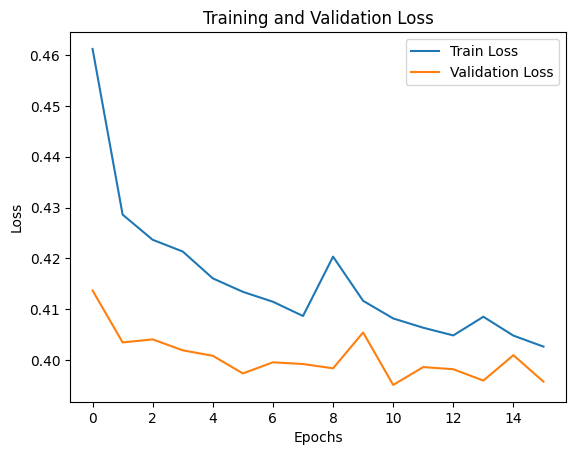

In [387]:
train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=150)

 Вычисление метрик

In [388]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score

# Вычисление метрик на валидационных данных
model.eval()
with torch.no_grad():
    y_val_pred_proba = model(X_val_tensor.to(device)).cpu().numpy().flatten()
    y_val_pred = (y_val_pred_proba >= 0.5).astype(int)

# Вычисление метрик
roc_auc = roc_auc_score(y_val, y_val_pred_proba)
f1 = f1_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
accuracy = accuracy_score(y_val, y_val_pred)

# Вывод метрик
print(f"Validation ROC AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")


Validation ROC AUC: 0.8869
F1 Score: 0.7274
Precision: 0.7154
Recall: 0.7399
Accuracy: 0.7947


In [389]:
# Предсказание вероятностей на тестовых данных
with torch.no_grad():
    test_predictions = model(X_test_tensor.to(device)).cpu().numpy()

# Формирование файла отправки
submission = pd.DataFrame({'id': test_data['id'], 'smoking': test_predictions.flatten()})
submission.to_csv('submission.csv', index=False)
